<a href="https://colab.research.google.com/github/JLmm123/deep_learning/blob/main/Milestone3_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install torchinfo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import gdown

import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from google.colab import drive
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from torch.utils.data import TensorDataset


In [ ]:
if not os.path.exists('./data'):
    os.mkdir('./data')

In [ ]:
if not os.path.exists('./data/IMDB Dataset.csv.zip'):
    gdown.download(id='1q1JkdXgCELu2aIHpxmSwCzYYYU7B-Phd', output='./data/IMDB Dataset.csv.zip')

!yes n | unzip './data/IMDB Dataset.csv.zip' -d './data/'

nlp_df = pd.read_csv('./data/IMDB Dataset.csv')

nlp_df

Downloading...
From: https://drive.google.com/uc?id=1q1JkdXgCELu2aIHpxmSwCzYYYU7B-Phd
To: /content/data/IMDB Dataset.csv.zip
100%|██████████| 27.0M/27.0M [00:00<00:00, 73.0MB/s]


Archive:  ./data/IMDB Dataset.csv.zip
  inflating: ./data/IMDB Dataset.csv  


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Create a label coumn of 0 and 1

In [ ]:
nlp_df['label'] = nlp_df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from bs4 import BeautifulSoup
def remove_html_tags(s):
  soup = BeautifulSoup(s, "html.parser")
  return soup.get_text() if s else None

nlp_df['review'] = nlp_df['review'].apply(lambda x: remove_html_tags(x))
#reduce sample size to do training. Will size up for testing and validation.
nlp_df_reduced = nlp_df

<ipython-input-7-07959701cc40>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(s, "html.parser")


In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
def get_lemmatized_tokens(text):
    tokens = word_tokenize(text)
    filtered_words = [lemmatizer.lemmatize(word.lower()) for word in tokens
                      if len(word) > 2 and word.isalpha()
                      and not word.lower() in stop_words]
    return filtered_words


In [ ]:
# tokenize each comment
lemmatized_tokens = list(map(get_lemmatized_tokens, nlp_df['review'].values))
print(lemmatized_tokens[: 2])

[['one', 'reviewer', 'mentioned', 'watching', 'episode', 'hooked', 'right', 'exactly', 'happened', 'first', 'thing', 'struck', 'brutality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'called', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inwards', 'privacy', 'high', 'agenda', 'city', 'home', 'many', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'never', 'far', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'go', 'show', 'would', 'dare', 'forget', 'pretty', 'picture', 'painted', 'mainstream', 'audience', 'forget', 'charm', 'forget', 'romance', 'mess', 'around', 'first', 'episode', 'ever',

In [ ]:
lemmatized_reviews = list(map(' '.join, lemmatized_tokens))
lemmatized_reviews[: 2]

['one reviewer mentioned watching episode hooked right exactly happened first thing struck brutality unflinching scene violence set right word trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use called nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far would say main appeal show due fact go show would dare forget pretty picture painted mainstream audience forget charm forget romance mess around first episode ever saw struck nasty surreal could say ready watched developed taste got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching may become comfortable

Create the "vocabulary" to index mapping
<SOS> and <EOS> are short for "start of sentence" and "end of sentence" respectively.
They are tokens used to identify the beginning and ending of each sentence in order to train the model.
They will be inserted at the beginning and end of every sentence


In [ ]:
nlp_df_reduced['lemmatized_tokens'] = nlp_df_reduced['review'].apply(lambda x: get_lemmatized_tokens(x))


In [ ]:
word_list=[]
def collect_all_word(x):
  word_list.extend(x)

In [ ]:
nlp_df_reduced['lemmatized_tokens'].apply(lambda x: collect_all_word(x))

0        None
1        None
2        None
3        None
4        None
         ... 
49995    None
49996    None
49997    None
49998    None
49999    None
Name: lemmatized_tokens, Length: 50000, dtype: object

In [ ]:
counter = Counter(word_list)

top_words = [word for word, count in counter.most_common(1000)]

In [ ]:
len(set(top_words))

1000

In [ ]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]
index2word.extend(top_words)

In [ ]:
index2word[10]

'would'

In [ ]:
word2index = {token: idx for idx, token in enumerate(index2word)}

In [ ]:
word2index["bad"]

23

In [ ]:
sen_length = 80

In [ ]:
def encode_and_pad(sen, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    encoded = [word2index[w] for w in sen if w in top_words]
    if len(encoded) >length-2:
      truncated = encoded[:length-2]
      return sos + truncated + eos
    else:
      n_pads = length - 2 - len(encoded)
    return  sos + encoded + eos + pad * n_pads


In [ ]:
nlp_df_reduced['encoded_sentence'] = nlp_df_reduced['lemmatized_tokens'].apply(lambda x: encode_and_pad(x,sen_length))

In [ ]:
print(nlp_df_reduced['encoded_sentence'][10])

[1, 670, 5, 4, 337, 91, 169, 144, 636, 26, 870, 87, 70, 3, 56, 289, 70, 350, 273, 4, 41, 179, 87, 119, 9, 684, 314, 649, 4, 10, 57, 581, 49, 122, 298, 72, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
data_encoded = nlp_df_reduced[['encoded_sentence', 'label']]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(list(data_encoded['encoded_sentence']), list(data_encoded['label']), test_size=0.3, random_state=42)


In [ ]:
len(X_train[0]),len(X_train[1])

(80, 80)

In [ ]:
train_x = np.array(X_train)
train_y = np.array(y_train)
test_x = np.array(X_test)
test_y = np.array(y_test)

In [ ]:
test_x.shape

In [ ]:
batch_size = 50


train_ds = TensorDataset(torch.tensor(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [ ]:
from torchinfo import summary

In [ ]:
no_layers = 2
vocab_size = len(word2index) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

In [ ]:
summary(model)

In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 30
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_dl:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in test_dl:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_dl.dataset)
    epoch_val_acc = val_acc/len(test_dl.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    # if epoch_val_loss <= valid_loss_min:
    #     torch.save(model.state_dict(), '../working/state_dict.pt')
    #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    #     valid_loss_min = epoch_val_loss
    # print(25*'==')


In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

# Hyperparameter tuning

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
# TODO: Define your parameter grid. pgrid should
# just be the wrapped version of param_grid using ParameterGrid
# num_epochs will be the number of epochs you use to grid search and train

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'embedding_dim': [32, 64, 128],
    'hidden_dim': [128, 256, 512],
    'no_layers': [1, 2, 3],
}
pgrid = ParameterGrid(param_grid)

num_epochs = 25
output_dim = 1

In [ ]:
# TODO: Conduct your grid search.
# Training loop
best_accuracy = 0.0
best_params = None

for params in pgrid:
    print(params)
    model = SentimentRNN(
        no_layers=params['no_layers'],
        vocab_size=len(word2index) + 1, #extra 1 for padding
        hidden_dim=params['hidden_dim'],
        embedding_dim=params['embedding_dim'],
        drop_prob=0.5
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    epoch = num_epochs
    clip = 5
    valid_loss_min = np.Inf
    # train for some number of epochs
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]

    for epoch in range(epoch):
      train_losses = []
      train_acc = 0.0
      model.train()
      # initialize hidden state
      h = model.init_hidden(batch_size)
      for inputs, labels in train_dl:

          inputs, labels = inputs.to(device), labels.to(device)
          # Creating new variables for the hidden state, otherwise
          # we'd backprop through the entire training history
          h = tuple([each.data for each in h])

          model.zero_grad()
          output,h = model(inputs,h)

          # calculate the loss and perform backprop
          loss = criterion(output.squeeze(), labels.float())
          loss.backward()
          # train_losses.append(loss.item())
          # calculating accuracy
          # accuracy = acc(output,labels)
          # train_acc += accuracy
          #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
          nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()

      val_h = model.init_hidden(batch_size)
      val_losses = []
      val_acc = 0.0
      model.eval()
      for inputs, labels in test_dl:
              val_h = tuple([each.data for each in val_h])

              inputs, labels = inputs.to(device), labels.to(device)

              output, val_h = model(inputs, val_h)
              val_loss = criterion(output.squeeze(), labels.float())

              val_losses.append(val_loss.item())

              accuracy = acc(output,labels)
              val_acc += accuracy

      epoch_val_acc = val_acc/len(test_dl.dataset)
      epoch_vl_acc.append(epoch_val_acc)

    val_acc_final = np.mean(np.array(epoch_vl_acc))
    # Check if the current set of parameters gives a better training accuracy
    if val_acc_final > best_accuracy:
        best_accuracy = val_acc_final
        best_params = params

In [ ]:
best_accuracy

In [ ]:
best_params

Train using the best parameters

In [ ]:
no_layers = 2
vocab_size = len(word2index) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 128


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

In [ ]:
# loss and optimization functions
lr=0.01

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 50
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_dl:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in test_dl:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_dl.dataset)
    epoch_val_acc = val_acc/len(test_dl.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    # if epoch_val_loss <= valid_loss_min:
    #     torch.save(model.state_dict(), '../working/state_dict.pt')
    #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    #     valid_loss_min = epoch_val_loss
    # print(25*'==')


In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
# # function to predict accuracy
# def acc(pred,label):
#     pred = torch.round(pred.squeeze())
#     return torch.sum(pred == label.squeeze()).item()
# # Define the hyperparameters to tune
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'embedding_dim': [32, 64, 128],
#     'hidden_dim': [128, 256, 512],
#     'no_layers': [1, 2, 3],
# }

# # Create a function for model training with cross-validation
# def train_model(params, X_train, y_train, X_val, y_val):
#     train_ds = TensorDataset(torch.tensor(X_train), torch.from_numpy(y_train))
#     train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
#     accuracies = []
#     model = SentimentRNN(
#         no_layers=params['no_layers'],
#         vocab_size=vocab_size,
#         hidden_dim=params['hidden_dim'],
#         embedding_dim=params['embedding_dim'],
#         drop_prob=0.5
#     )

#     model.to(device)
#     criterion = nn.BCELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

#     clip = 5
#     epochs = 20
#     valid_loss_min = np.Inf
#     # train for some number of epochs
#     epoch_tr_loss,epoch_vl_loss = [],[]
#     epoch_tr_acc,epoch_vl_acc = [],[]

#     for epoch in range(epochs):
#       # train_losses = []
#       # train_acc = 0.0
#       model.train()
#       # initialize hidden state
#       h = model.init_hidden(batch_size)
#       for inputs, labels in train_dl:

#           inputs, labels = inputs.to(device), labels.to(device)
#           # Creating new variables for the hidden state, otherwise
#           # we'd backprop through the entire training history
#           h = tuple([each.data for each in h])

#           model.zero_grad()
#           output,h = model(inputs,h)

#           # calculate the loss and perform backprop
#           loss = criterion(output.squeeze(), labels.float())
#           loss.backward()
#           # train_losses.append(loss.item())
#           # calculating accuracy
#           # accuracy = acc(output,labels)
#           # train_acc += accuracy
#           #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
#           nn.utils.clip_grad_norm_(model.parameters(), clip)
#           optimizer.step()

#     # Calculate accuracy on the validation fold
#     val_accuracy = calculate_validation_accuracy(model, X_val, y_val)
#     accuracies.append(val_accuracy)

#     return np.mean(accuracies)  # Use the mean validation accuracy for hyperparameter tuning

# def calculate_validation_accuracy(model, X_val, y_val):
#     # Implement this function to calculate the validation accuracy
#     # You can reuse parts of your existing validation code here
#     # Make sure to move the model to the correct device before using it on validation data
#     # Return the validation accuracy
#     val_ds = TensorDataset(torch.tensor(X_val), torch.from_numpy(y_val))
#     test_dl = DataLoader(val_ds, shuffle=True, batch_size=batch_size, drop_last=True)

#     val_h = model.init_hidden(batch_size)
#     val_losses = []
#     val_acc = 0.0
#     model.eval()
#     for inputs, labels in test_dl:
#             val_h = tuple([each.data for each in val_h])

#             inputs, labels = inputs.to(device), labels.to(device)

#             output, val_h = model(inputs, val_h)
#             val_loss = criterion(output.squeeze(), labels.float())

#             val_losses.append(val_loss.item())

#             accuracy = acc(output,labels)
#             val_acc += accuracy
#     return val_acc

# # Create an instance of the SentimentRNN model
# base_model = SentimentRNN(
#     no_layers=2,
#     vocab_size=len(word2index) + 1, #extra 1 for padding
#     hidden_dim=256,
#     embedding_dim=64,
#     drop_prob=0.5
# )
# # Create GridSearchCV
# grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='accuracy', cv=3)

# # Perform Grid Search
# grid_search.fit(X_train, y_train)  # Provide your training data

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# best_params

In [ ]:

# Retrain the model with the best hyperparameters on the entire training dataset
best_model = SentimentRNN(
    no_layers=best_params['no_layers'],
    vocab_size=vocab_size,
    hidden_dim=best_params['hidden_dim'],
    embedding_dim=best_params['embedding_dim'],
    drop_prob=0.5
)
best_model.to(device)
# Retrain the model on the entire training dataset
# ...

# Evaluate the model on your test dataset
# test_accuracy = evaluate_test_accuracy(best_model, X_test, y_test)
# print(f'Test Accuracy: {test_accuracy}')


# Datashift

Planning to train on short sentences and test on long sentences, first observe the sentence length distribution

In [ ]:
nlp_df_reduced

,review,sentiment,label,lemmatized_tokens,encoded_sentence
0,One of the other reviewers has mentioned that ...,positive,1,"[one, reviewer, mentioned, watching, episode, ...","[1, 5, 979, 898, 65, 163, 97, 474, 457, 26, 28..."
1,A wonderful little production. The filming tec...,positive,1,"[wonderful, little, production, filming, techn...","[1, 275, 46, 225, 59, 400, 183, 310, 223, 37, ..."
2,I thought this was a wonderful way to spend ti...,positive,1,"[thought, wonderful, way, spend, time, hot, su...","[1, 89, 275, 27, 946, 7, 748, 758, 468, 65, 94..."
3,Basically there's a family where a little boy ...,negative,0,"[basically, family, little, boy, jake, think, ...","[1, 550, 116, 46, 193, 30, 501, 536, 834, 3, 9..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,"[petter, mattei, love, time, money, visually, ...","[1, 34, 7, 186, 4, 33, 664, 235, 3, 90, 857, 1..."
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1,"[thought, movie, right, good, job, creative, o...","[1, 89, 3, 97, 8, 170, 110, 26, 826, 117, 146,..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,"[bad, plot, bad, dialogue, bad, acting, idioti...","[1, 23, 39, 23, 270, 23, 43, 800, 500, 563, 12..."
49997,I am a Catholic taught in parochial elementary...,negative,0,"[catholic, taught, parochial, elementary, scho...","[1, 251, 218, 251, 930, 53, 10, 8, 231, 158, 6..."
49998,I'm going to have to disagree with the previou...,negative,0,"[going, disagree, previous, comment, side, mal...","[1, 75, 737, 326, 334, 5, 194, 811, 570, 159, ..."


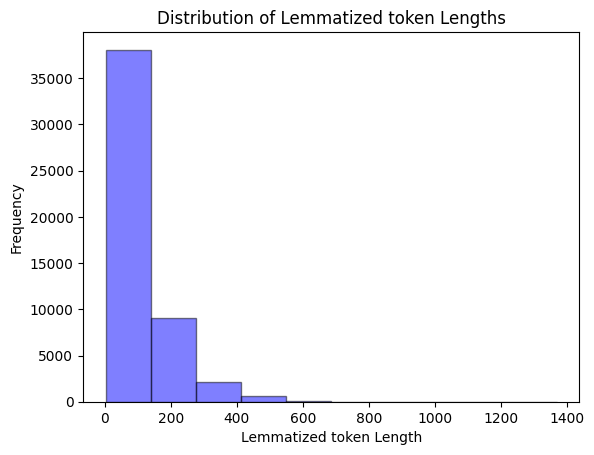

In [ ]:
lengths = [len(sequence) for sequence in nlp_df_reduced['lemmatized_tokens']]

# Plotting the distribution
plt.hist(lengths, bins=10, alpha=0.5, color='b', edgecolor='black')
plt.title('Distribution of Lemmatized token Lengths')
plt.xlabel('Lemmatized token Length')
plt.ylabel('Frequency')
plt.show()

We choose the threhold to be 200

In [ ]:
short_reviews_count = sum(len(review) < 200 for review in nlp_df_reduced['lemmatized_tokens'])
long_reviews_count = sum(len(review) >= 200 for review in nlp_df_reduced['lemmatized_tokens'])
print(short_reviews_count, long_reviews_count)

43848 6152


The train_test split will be approximately 7:1, which is rational

In [ ]:
short_reviews = nlp_df_reduced[[len(review) < 200 for review in nlp_df_reduced['lemmatized_tokens']]][['lemmatized_tokens','encoded_sentence', 'label']]
long_reviews = nlp_df_reduced[[len(review) >= 200 for review in nlp_df_reduced['lemmatized_tokens']]][['lemmatized_tokens','encoded_sentence', 'label']]

In [ ]:
len(short_reviews)

43848

In [ ]:
X_train_sl, X_test_sl = list(short_reviews['encoded_sentence']), list(long_reviews['encoded_sentence'])
y_train_sl, y_test_sl = list(short_reviews['label']), list(long_reviews['label'])
train_x_sl = np.array(X_train_sl)
train_y_sl = np.array(y_train_sl)
test_x_sl = np.array(X_test_sl)
test_y_sl = np.array(y_test_sl)

In [ ]:
short_reviews['lemmatized_tokens']

0        [one, reviewer, mentioned, watching, episode, ...
1        [wonderful, little, production, filming, techn...
2        [thought, wonderful, way, spend, time, hot, su...
3        [basically, family, little, boy, jake, think, ...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [thought, movie, right, good, job, creative, o...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [catholic, taught, parochial, elementary, scho...
49998    [going, disagree, previous, comment, side, mal...
49999    [one, expects, star, trek, movie, high, art, f...
Name: lemmatized_tokens, Length: 43848, dtype: object

In [ ]:
X_train_sl_tra, X_test_sl_tra = short_reviews['lemmatized_tokens'],long_reviews['lemmatized_tokens']
y_train_sl_tra, y_test_sl_tra = short_reviews['label'], long_reviews['label']
X_train_sl_tra = [' '.join(sublist) for sublist in X_train_sl_tra]
X_test_sl_tra = [' '.join(sublist) for sublist in X_test_sl_tra]

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


model = make_pipeline(TfidfVectorizer(ngram_range=(2, 2)), LogisticRegression(max_iter=250, random_state=42,penalty='l2'))
model.fit(X_train_sl_tra, y_train_sl_tra)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(2, 2))),
                ('logisticregression',
                 LogisticRegression(max_iter=250, random_state=42))])

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_sl_tra)

print(classification_report(y_test_sl_tra, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2856
           1       0.88      0.87      0.87      3296

    accuracy                           0.87      6152
   macro avg       0.86      0.87      0.86      6152
weighted avg       0.87      0.87      0.87      6152



In [ ]:
train_x_sl

array([[  1,   5, 979, ..., 578, 518,   2],
       [  1, 275,  46, ...,   0,   0,   0],
       [  1,  89, 275, ...,   0,   0,   0],
       ...,
       [  1, 251, 218, ...,   0,   0,   0],
       [  1,  75, 737, ...,   0,   0,   0],
       [  1,   5, 104, ...,   0,   0,   0]])

In [ ]:
batch_size = 50

train_ds = TensorDataset(torch.tensor(train_x_sl), torch.from_numpy(train_y_sl))
test_ds = TensorDataset(torch.from_numpy(test_x_sl), torch.from_numpy(test_y_sl))

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
no_layers = 2
vocab_size = len(word2index) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1004, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 30
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_dl:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in test_dl:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_dl.dataset)
    epoch_val_acc = val_acc/len(test_dl.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    # if epoch_val_loss <= valid_loss_min:
    #     torch.save(model.state_dict(), '../working/state_dict.pt')
    #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    #     valid_loss_min = epoch_val_loss
    # print(25*'==')

Epoch 1
train_loss : 0.6930220885772139 val_loss : 0.6950908017352344
train_accuracy : 51.163108921729616 val_accuracy : 46.55396618985696
Epoch 2
train_loss : 0.6927524059330492 val_loss : 0.7030995061727074
train_accuracy : 50.866630176975 val_accuracy : 46.47269180754226
Epoch 3
train_loss : 0.6927119894250887 val_loss : 0.7067771394078325
train_accuracy : 51.31590950556468 val_accuracy : 46.4076723016905
Epoch 4
train_loss : 0.6902802571586278 val_loss : 0.718945890422759
train_accuracy : 52.66146688560481 val_accuracy : 46.814044213263976
Epoch 5
train_loss : 0.45356429310421964 val_loss : 0.5056152666002754
train_accuracy : 79.15298303229338 val_accuracy : 75.9590377113134
Epoch 6
train_loss : 0.34836772667694854 val_loss : 0.4857875399473237
train_accuracy : 84.64468162744025 val_accuracy : 77.94213263979194
Epoch 7
train_loss : 0.3169465219287295 val_loss : 0.4910872452627353
train_accuracy : 86.3596971355592 val_accuracy : 77.4219765929779
Epoch 8
train_loss : 0.29753484990294

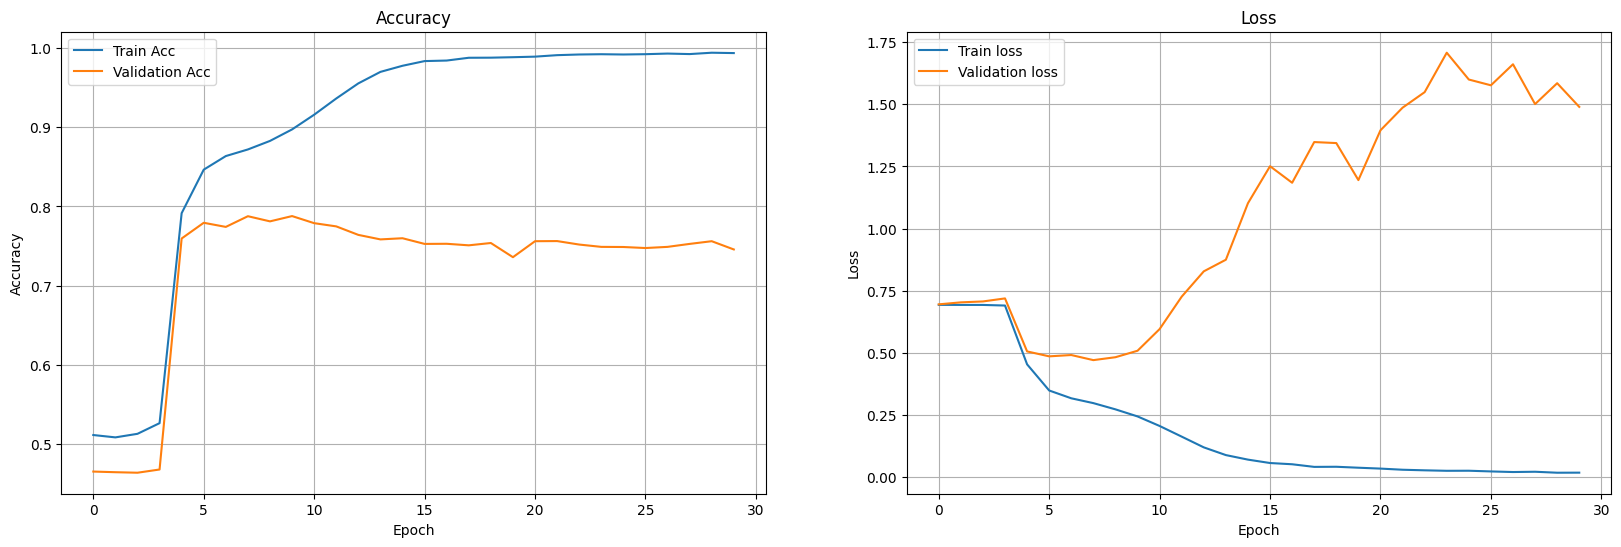

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.show()

# change a way so that train on long and test on short, the threshold is now word length of 50

In [ ]:
short_reviews = nlp_df_reduced[[len(review) < 50 for review in nlp_df_reduced['lemmatized_tokens']]][['lemmatized_tokens', 'encoded_sentence', 'label']]
long_reviews = nlp_df_reduced[[len(review) >= 50 for review in nlp_df_reduced['lemmatized_tokens']]][['lemmatized_tokens', 'encoded_sentence', 'label']]

In [ ]:
len(short_reviews)

6874

In [ ]:
len(long_reviews)

43126

In [ ]:
X_train_sl, X_test_sl = list(long_reviews['lemmatized_tokens']), list(short_reviews['lemmatized_tokens'])
y_train_sl, y_test_sl = list(long_reviews['label']), list(short_reviews['label'])
train_x_sl = np.array(X_train_sl)
train_y_sl = np.array(y_train_sl)
test_x_sl = np.array(X_test_sl)
test_y_sl = np.array(y_test_sl)

<ipython-input-106-986be8ae941b>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_x_sl = np.array(X_train_sl)
<ipython-input-106-986be8ae941b>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_x_sl = np.array(X_test_sl)


In [ ]:
len(train_x_sl)

43126

In [ ]:
X_train_sl_tra, X_test_sl_tra = long_reviews['lemmatized_tokens'],short_reviews['lemmatized_tokens']
y_train_sl_tra, y_test_sl_tra = long_reviews['label'], short_reviews['label']
X_train_sl_tra = [' '.join(sublist) for sublist in X_train_sl_tra]
X_test_sl_tra = [' '.join(sublist) for sublist in X_test_sl_tra]

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


model = make_pipeline(TfidfVectorizer(ngram_range=(2, 2)), LogisticRegression(max_iter=250, random_state=42,penalty='l2'))
model.fit(X_train_sl_tra, y_train_sl_tra)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(2, 2))),
                ('logisticregression',
                 LogisticRegression(max_iter=250, random_state=42))])

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_sl_tra)

print(classification_report(y_test_sl_tra, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      3202
           1       0.85      0.88      0.86      3672

    accuracy                           0.85      6874
   macro avg       0.85      0.85      0.85      6874
weighted avg       0.85      0.85      0.85      6874



In [ ]:
batch_size = 50

train_ds = TensorDataset(torch.tensor(train_x_sl), torch.from_numpy(train_y_sl))
test_ds = TensorDataset(torch.from_numpy(test_x_sl), torch.from_numpy(test_y_sl))

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
len(train_dl)

862

In [ ]:
no_layers = 2
vocab_size = len(word2index) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1004, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 30
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_dl:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in test_dl:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_dl.dataset)
    epoch_val_acc = val_acc/len(test_dl.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    # if epoch_val_loss <= valid_loss_min:
    #     torch.save(model.state_dict(), '../working/state_dict.pt')
    #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    #     valid_loss_min = epoch_val_loss
    # print(25*'==')

Epoch 1
train_loss : 0.6932381233178823 val_loss : 0.6945430079515833
train_accuracy : 51.041135278022544 val_accuracy : 46.450392784405004
Epoch 2
train_loss : 0.6925290195128757 val_loss : 0.689093341792587
train_accuracy : 50.3825998237722 val_accuracy : 46.42129764329357
Epoch 3
train_loss : 0.6911937665635085 val_loss : 0.6941481219591016
train_accuracy : 52.406900709548765 val_accuracy : 46.39220250218214
Epoch 4
train_loss : 0.5374444216109484 val_loss : 0.4154796119589005
train_accuracy : 70.82502434726152 val_accuracy : 81.87372708757637
Epoch 5
train_loss : 0.37040064563399955 val_loss : 0.3479902856323841
train_accuracy : 83.81718684784121 val_accuracy : 84.47774221704975
Epoch 6
train_loss : 0.33763924676691576 val_loss : 0.33356764618932766
train_accuracy : 85.42874368130595 val_accuracy : 84.87052662205411
Epoch 7
train_loss : 0.31507276287280767 val_loss : 0.32481493762809865
train_accuracy : 86.3516208319807 val_accuracy : 85.37969159150421
Epoch 8
train_loss : 0.292575

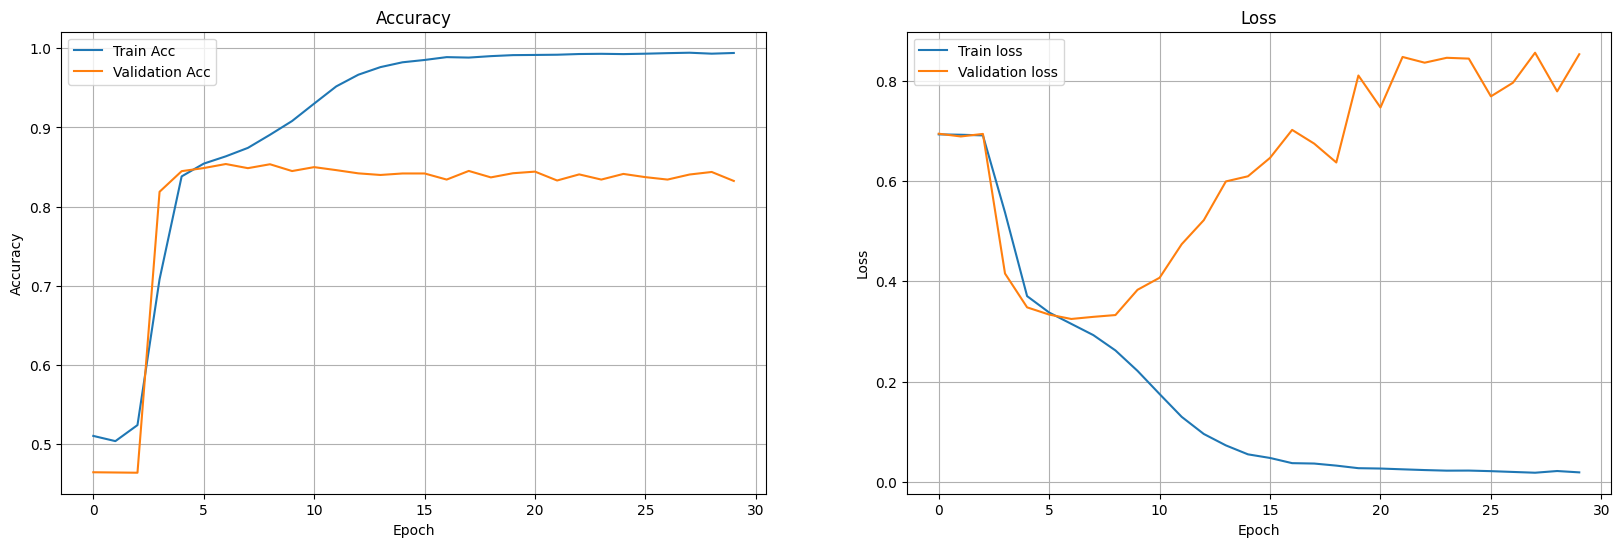

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.show()

# Train on less than 80 test on more than 200

In [ ]:
short_reviews_count = sum(len(review) < 80 for review in nlp_df_reduced['lemmatized_tokens'])
long_reviews_count = sum(len(review) >= 200 for review in nlp_df_reduced['lemmatized_tokens'])
print(short_reviews_count, long_reviews_count)

23554 6152


In [ ]:
short_reviews = nlp_df_reduced[[len(review) < 80 for review in nlp_df_reduced['lemmatized_tokens']]][['lemmatized_tokens','label']]
long_reviews = nlp_df_reduced[[len(review) >= 200 for review in nlp_df_reduced['lemmatized_tokens']]][['lemmatized_tokens','label']]

In [ ]:
from sklearn.utils import resample

In [ ]:
# Resample the majority class to achieve an 8:2 ratio
upsampled_short_reviews = resample(short_reviews, replace=True, n_samples=int(8 * len(long_reviews)), random_state=42)


In [ ]:
X_train_sl_tra, X_test_sl_tra = short_reviews['lemmatized_tokens'],long_reviews['lemmatized_tokens']
y_train_sl_tra, y_test_sl_tra = short_reviews['label'], long_reviews['label']
X_train_sl_tra = [' '.join(sublist) for sublist in X_train_sl_tra]
X_test_sl_tra = [' '.join(sublist) for sublist in X_test_sl_tra]

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


model = make_pipeline(TfidfVectorizer(ngram_range=(2, 2)), LogisticRegression(max_iter=250, random_state=42,penalty='l2'))
model.fit(X_train_sl_tra, y_train_sl_tra)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(2, 2))),
                ('logisticregression',
                 LogisticRegression(max_iter=250, random_state=42))])

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_sl_tra)

print(classification_report(y_test_sl_tra, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2856
           1       0.86      0.84      0.85      3296

    accuracy                           0.84      6152
   macro avg       0.84      0.84      0.84      6152
weighted avg       0.84      0.84      0.84      6152



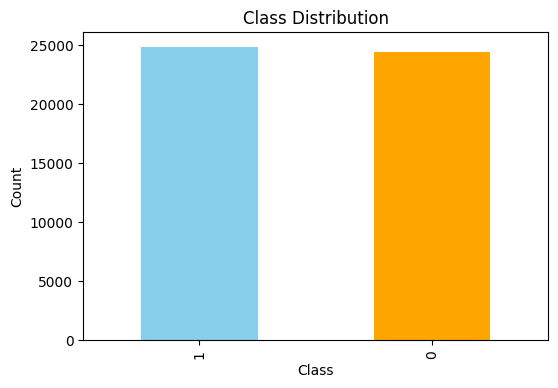

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
upsampled_short_reviews['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

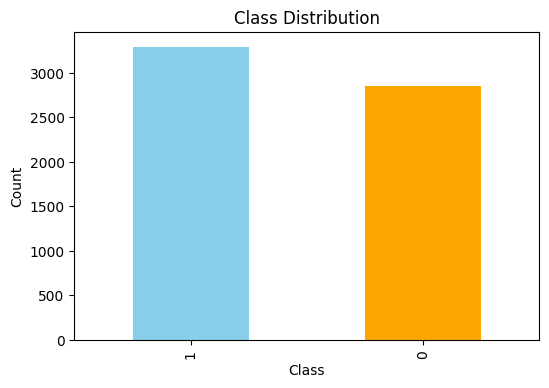

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
long_reviews['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
X_train_sl, X_test_sl = list(upsampled_short_reviews['encoded_sentence']), list(long_reviews['encoded_sentence'])
y_train_sl, y_test_sl = list(upsampled_short_reviews['label']), list(long_reviews['label'])


In [ ]:
print(len(X_train_sl))

49216


In [ ]:
train_x_sl = np.array(X_train_sl)
train_y_sl = np.array(y_train_sl)
test_x_sl = np.array(X_test_sl)
test_y_sl = np.array(y_test_sl)

In [ ]:
batch_size = 50

train_ds = TensorDataset(torch.tensor(train_x_sl), torch.from_numpy(train_y_sl))
test_ds = TensorDataset(torch.from_numpy(test_x_sl), torch.from_numpy(test_y_sl))

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
no_layers = 2
vocab_size = len(word2index) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1004, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 30
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_dl:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in test_dl:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_dl.dataset)
    epoch_val_acc = val_acc/len(test_dl.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    # if epoch_val_loss <= valid_loss_min:
    #     torch.save(model.state_dict(), '../working/state_dict.pt')
    #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    #     valid_loss_min = epoch_val_loss
    # print(25*'==')

Epoch 1
train_loss : 0.693454271651865 val_loss : 0.6920169276919791
train_accuracy : 50.268205461638495 val_accuracy : 53.543563068920676
Epoch 2
train_loss : 0.6932200304255253 val_loss : 0.692983019158123
train_accuracy : 50.12800715214565 val_accuracy : 52.97464239271782
Epoch 3
train_loss : 0.6931852809176212 val_loss : 0.6932453750594845
train_accuracy : 50.292587776332894 val_accuracy : 46.53771131339402
Epoch 4
train_loss : 0.693170902750841 val_loss : 0.6926973462104797
train_accuracy : 50.199122236671 val_accuracy : 53.559817945383614
Epoch 5
train_loss : 0.6931844996969875 val_loss : 0.6925572815949355
train_accuracy : 50.35151170351105 val_accuracy : 53.559817945383614
Epoch 6
train_loss : 0.6931804600285321 val_loss : 0.6925684262097367
train_accuracy : 50.217408972691814 val_accuracy : 53.57607282184655
Epoch 7
train_loss : 0.6931435758990001 val_loss : 0.69266772560957
train_accuracy : 50.12394343302991 val_accuracy : 53.57607282184655
Epoch 8
train_loss : 0.693144413695

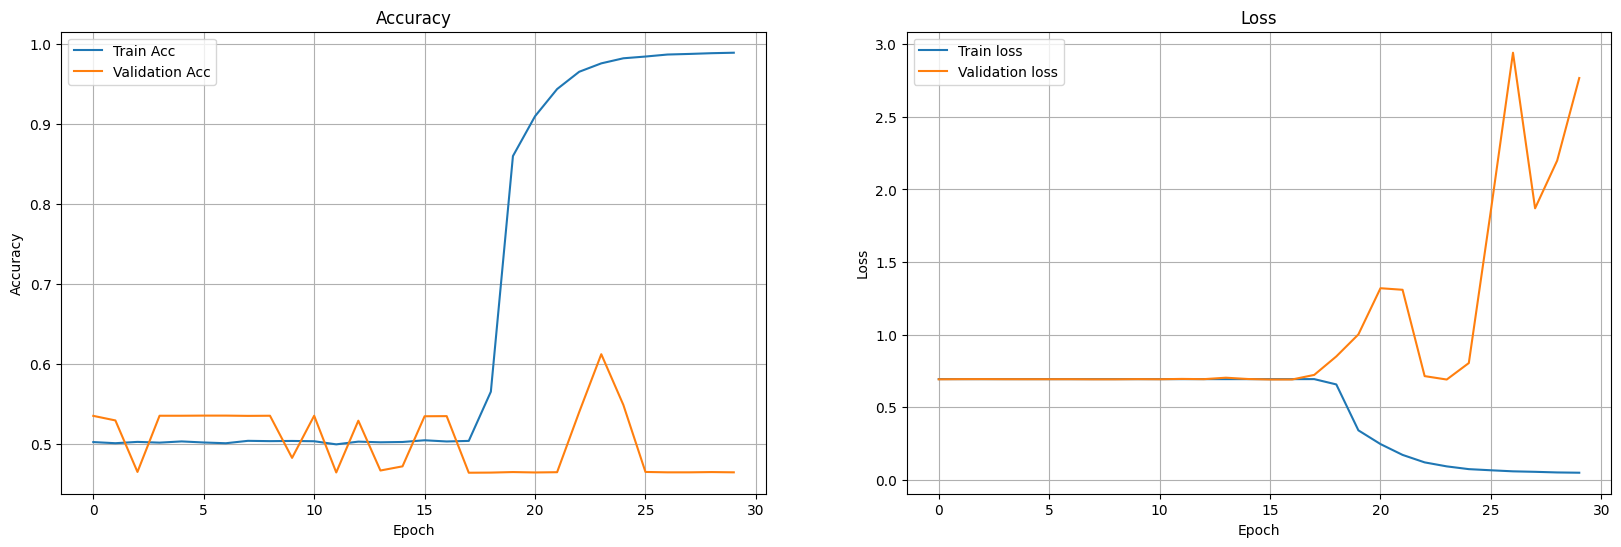

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.show()



# Another model

In [ ]:
class BiLSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden

    def init_hidden(self):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))

In [ ]:
model = BiLSTM_SentimentAnalysis(len(word2index), 64, 32, 0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [ ]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []

epochs = 50
losses = []

for e in range(epochs):
    h0, c0 = model.init_hidden()
    h0 = h0.to(device)
    c0 = c0.to(device)

    running_loss = 0.0
    correct, total = 0, 0

    for batch_idx, batch in enumerate(train_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(out, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    losses.append(loss.item())
    train_loss.append(running_loss / len(train_dl))
    train_acc.append(correct / total)

    if (e + 1) % 5 == 0:
        print(f"Epoch {e + 1}:")
        print(f"Training Loss: {train_loss[-1]:.3f}")
        print(f"Training Accuracy: {100 * train_acc[-1]:.2f}%")
        print("------------------------------")


Epoch 5:
Training Loss: 0.721
Training Accuracy: 50.43%
------------------------------
Epoch 10:
Training Loss: 0.698
Training Accuracy: 53.24%
------------------------------
Epoch 15:
Training Loss: 0.692
Training Accuracy: 52.43%
------------------------------
Epoch 20:
Training Loss: 0.671
Training Accuracy: 56.29%
------------------------------
Epoch 25:
Training Loss: 0.645
Training Accuracy: 64.29%
------------------------------
Epoch 30:
Training Loss: 0.670
Training Accuracy: 57.71%
------------------------------
Epoch 35:
Training Loss: 0.592
Training Accuracy: 70.62%
------------------------------
Epoch 40:
Training Loss: 0.679
Training Accuracy: 55.43%
------------------------------
Epoch 45:
Training Loss: 0.667
Training Accuracy: 55.67%
------------------------------
Epoch 50:
Training Loss: 0.659
Training Accuracy: 55.95%
------------------------------


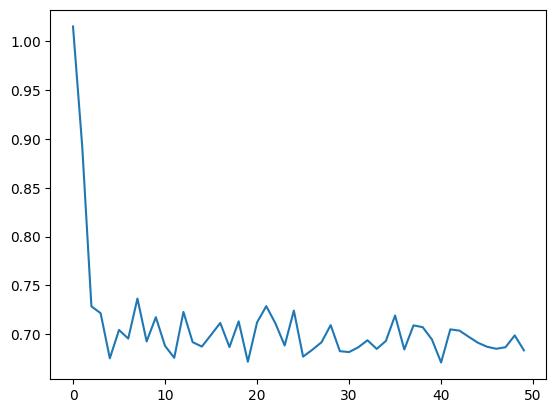

In [ ]:
plt.plot(losses)

In [ ]:
from sklearn.metrics import accuracy_score
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

NameError: ignored

NameError: ignored

# bigram(saved for later)

In [ ]:
from nltk import bigrams
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(text):
  # Convert the bigrams back to text for TF-IDF analysis
  #bi_grams_text = [' '.join([' '.join(gram) for gram in grams]) for grams in bigrams]
  # Compute TF-IDF scores
  #print (bi_grams_text)
  vectorizer = TfidfVectorizer(ngram_range = (2, 2))
  X = vectorizer.fit_transform(text)

  # Get feature names (bigrams)
  feature_names = vectorizer.get_feature_names_out()
  print(feature_names)
  # Compute TF-IDF scores for each bigram
  #tfidf_scores = X.toarray()
  sums = X.sum(axis=0)
  data = []
  for col, term in enumerate(feature_names):
    data.append((term, sums[0, col]))
  ranking = pd.DataFrame(data, columns=['term', 'rank'])
  top_500_tfidf = ranking.sort_values('rank', ascending=False)[:500]

  return top_500_tfidf

top_500_tfidf = tfidf(lemmatized_reviews)
top_500_tfidf


['aaa alcoholic' 'aaa ball' 'aaa even' ... 'četvorka another' 'יגאל כרמון'
 'כרמון president']


,term,rank
797863,ever seen,119.721338
1435614,look like,104.513067
1603637,movie ever,103.340889
2288166,special effect,96.545212
1711084,one best,86.445948
...,...,...
2439773,ten year,15.858268
676011,done better,15.841191
1011220,get movie,15.798961
902552,film still,15.775850


# Unigram (feature conversion)

In [ ]:
def tfidf(text, ngram=1):
  # Convert the bigrams back to text for TF-IDF analysis
  #bi_grams_text = [' '.join([' '.join(gram) for gram in grams]) for grams in bigrams]
  # Compute TF-IDF scores
  #print (bi_grams_text)
  vectorizer = TfidfVectorizer(ngram_range=(ngram, ngram))
  X = vectorizer.fit_transform(text)

  # Get feature names (bigrams)
  feature_names = vectorizer.get_feature_names_out()
  print(feature_names)
  # Compute TF-IDF scores for each bigram
  #tfidf_scores = X.toarray()
  sums = X.sum(axis=0)
  data = []
  for col, term in enumerate(feature_names):
    data.append((term, sums[0, col]))
  ranking = pd.DataFrame(data, columns=['term', 'rank'])
  top_500_tfidf = ranking.sort_values('rank', ascending=False)[:500]

  return X, top_500_tfidf

X, top_500_tfidf = tfidf(lemmatized_reviews)

['aaa' 'aaaaaaaaaaaahhhhhhhhhhhhhh' 'aaaaaaaargh' ... 'četvorka' 'יגאל'
 'כרמון']


In [ ]:
X

<50000x88792 sparse matrix of type '<class 'numpy.float64'>'
	with 4508003 stored elements in Compressed Sparse Row format>

In [ ]:
nlp_df

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


# Deep Learning